In [1]:
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid",context='talk', font_scale=1.1)
%matplotlib inline

In [2]:
import scipy as scp
import pandas as pd
import copy as cp
from tqdm import tqdm 
from itertools import cycle
import numpy as np
from scipy.signal import correlate2d

from copy import deepcopy

# global
fec_pars = {'A': {'OP50': [22.65, 68.45, 57.05, 33.4,  4.97], 'Novo': [11.66, 62.53, 47.13, 13.94,  0.72]},
            'C': {'OP50': [19.8 , 60.3 , 43.02, 19.9,  6.6], 'Novo': [16.88, 80.77, 77.7 , 16.28,  1.4]}}

#mf_prob = {'A': {'OP50': 0.11, 'Novo': 0.83}, 'C': {'OP50': 1.0, 'Novo': 1.0}}

mf_prob = {'A': {'OP50': 0.0, 'Novo': 0.83}, 'C': {'OP50': 1.0, 'Novo': 1.0}}

class Population(object):
    """Population object.
    """
    
    def __init__(self, n0, consumption=0.0, r0=1000, α=False):
        """Initialize the population object with an initial population vector.

        Args:
            n0 (numpy.ndarray): The initial composition of the population. 
            consumption (float, optional): Per capita consumption (excluding egg and dauer larvae). Defaults to 0.0.
            r0 (int, optional): Initial resource. Defaults to 1000.
        """
        self.pop = n0
        self.resource = r0
        self.α = α
        self.consumption = consumption
        self.diet_stat_pre = None
    
    @property
    def comb_f_mat(self):
        """Generate the fecundity block matrix.

        Returns:
            numpy.matrix: The block matrix containing the fecundity matrices. 
        """
        if self._diet != self.diet_stat_pre or not hasattr(self, 'f_mat_A'):
            self.f_mat_A = self.gen_fec_matrix('A', self.diet, 0.0415)
            self.f_mat_C = self.gen_fec_matrix('C', self.diet, 0.0415)
        return np.block([[self.f_mat_A, np.zeros((10,10))],
                        [np.zeros((10,10)), self.f_mat_C]])
        
    @property
    def diet(self):
        return self._diet
    
    @diet.setter
    def diet(self, d):
        if self.diet_stat_pre is None:
            self.diet_stat_pre = d
        else:
            self.diet_stat_pre = self._diet
        self._diet = d
        
    @property
    def u_mat(self):
        u_mat_A = self.generate_matrix(self.resource, self.diet, 'A')
        u_mat_C = self.generate_matrix(self.resource, self.diet, 'C')
        return (u_mat_A, u_mat_C)
    
    @property
    def comb_u_mat(self):
        """Generate the transition block matrix.

        Returns:
            numpy.matrix
        """
        u_A, u_C = self.u_mat
        # if not self.α or not self.mat_pred:
        comb_u_mat = np.block([[u_A, np.zeros((10,10))],
                               [np.zeros((10,10)), u_C]])
        return comb_u_mat
            
    @property
    def fund_mat(self):
        """Generate the fundamental matrices for the two strains in the population.

        Returns:
            tuple: strain A and strain c fundamental matrices 
        """
        u_A, u_C = self.u_mat
        return (np.linalg.inv(np.identity(10) - u_A), np.linalg.inv(np.identity(10) - u_C))
    
    @property
    def growth_rate(self):
        """Calculate the per generation growth rate (R0).

        Returns:
            tuple: leading Eigenvalues of A and strain c
        """
        fund_m = self.fund_mat
        return (np.linalg.eig(self.f_mat_A*fund_m[0])[0][0], np.linalg.eig(self.f_mat_C*fund_m[0])[0][0])
        
    @staticmethod
    def generate_matrix(r, diet, strain, r_min=100):
        """Generate the transition matrix.

        Args:
            r (float): Current resource level
            diet (str): Current diet
            strain (str): strain of interest
            r_min (int, optional): The minimum level of resource before switching to low resource condition. Defaults to 100.

        Returns:
            numpy.matrix
        """
        U = np.identity(10) * 0
        γ_JE  = lambda r: 0.0415 if r > r_min else 0.0
        γ_DJ = lambda r: 0.0415 if r < r_min else 0.0
        γ_YD = lambda r: 0.0415 if r > r_min else 0.0

        γ_YJ = lambda r: 0.0415 if r > r_min else 0.0
        if diet=='Novo':
            if strain == 'C':
                γ_RAY = 0.14
            else:
                γ_RAY = 0.12
        else:
            γ_RAY = 0.1
        γ_RR = 0.0415
        γ_OR = 0.0415
        δ_E = lambda r: 1 if r > r_min else 0.9
        δ_J = lambda r: 1 if r > r_min else 0.9
        δ_Y = lambda r: 1 if r > r_min else 0.9
        δ_RA = lambda r: 1 if r > r_min else 0.9
        δ_OA = lambda r: 0.995 if r > r_min else 0.9
        δ_D = 1
        U[0][0] = δ_E(r) * (1 - γ_JE(r))
        # juvenile ra(r)tes
        U[1][0] = δ_E(r) * γ_JE(r)
        U[1][1] = δ_J(r) * (1 - γ_YJ(r)) * (1 - γ_DJ(r))
        # dauer rates
        U[2][1] = δ_J(r) * γ_DJ(r)
        U[2][2] = δ_D * (1 - γ_YD(r))
        # young adults
        U[3][1] = δ_J(r) * γ_YJ(r)
        U[3][2] = δ_D * γ_YD(r)
        U[3][3] = δ_Y(r) * (1 - γ_RAY)
        # reproducing adults
        U[4][3] = δ_Y(r) * γ_RAY
        U[4][4] = δ_RA(r) * (1 - γ_RR)
        U[5][4] = δ_RA(r) * γ_RR
        U[5][5] = δ_RA(r) * (1 - γ_RR)
        U[6][5] = δ_RA(r) * γ_RR
        U[6][6] = δ_RA(r) * (1 - γ_RR)
        U[7][6] = δ_RA(r) * γ_RR
        U[7][7] = δ_RA(r) * (1 - γ_RR)
        U[8][7] = δ_RA(r) * γ_RR
        U[8][8] = δ_RA(r) * (1 - γ_OR)
        # old adults
        U[9][8] = δ_RA(r) * γ_OR
        U[9][9] = δ_OA(r)

        return np.matrix(U)
    
    @staticmethod
    def gen_fec_matrix(strain, food_type, rate):
        """Generate fecundity matrix.

        Args:
            strain (str): A (RSC017) or C (RS5405)
            food_type (str): The bacterial diet (Novo or OP50)

        Returns:
            numpy.matrix: fecundity values for each breeding developmental stage.
        """
        F = np.identity(10) * 0
        count = 0
        for i in np.arange(4, 9, 1):
            F[0][i] = rate*fec_pars[strain][food_type][count]
            count += 1
        return np.matrix(F)
    
    
    def predation(self):
        juvenile_a = deepcopy(self.pop[1][0]) 
        dauer_a = deepcopy(self.pop[2][0])
        predators_c = [self.pop[i][0] for i in np.arange(13, 20, 1)]
        killed_a_j = 0
        killed_a_d = 0
        for i in predators_c:
            killed_a_j += self.α * mf_prob['C'][self.diet] *  juvenile_a * i
            killed_a_d += self.α * mf_prob['C'][self.diet] *  dauer_a * i
        juvenile_a -= killed_a_j
        dauer_a -= killed_a_d
        if dauer_a < 0:
            dauer_a = 0
        if juvenile_a < 0:
            juvenile_a = 0
        # killing C
        juvenile_c = deepcopy(self.pop[11][0]) 
        dauer_c = deepcopy(self.pop[12][0])
        predators_a = [self.pop[i][0] for i in np.arange(3, 10, 1)]
        killed_c_j = 0
        killed_c_d = 0
        for i in predators_a:
            killed_c_j += self.α * mf_prob['A'][self.diet] *  juvenile_c * i
            killed_c_d += self.α * mf_prob['A'][self.diet] *  dauer_c * i
        juvenile_c -= killed_c_j
        dauer_c -= killed_c_d
        if dauer_c < 0:
            dauer_c = 0
        if juvenile_c < 0:
            juvenile_c = 0
        self.pop[1][0]  = juvenile_a 
        self.pop[2][0]  = dauer_a
        self.pop[11][0] = juvenile_c
        self.pop[12][0] = dauer_c
    
    def take_a_step(self):
        """Calculate the population composition at t+1.
        """
        self.pop = np.array(np.matmul(self.comb_u_mat + self.comb_f_mat, self.pop))
        if self.α > 0:
            self.predation()
        if self.consumption > 0.0:
            total_conusmers = self.pop[1][0] + np.sum(self.pop[3:10]) + self.pop[11][0] + np.sum(self.pop[13:20])
            self.resource -= self.consumption * total_conusmers
            if self.resource < 0:
                self.resource = 0

In [16]:
class Population2(object):
    """Population object.
    """
    
    def __init__(self, n0, consumption=0.0, r0=1000, α=False):
        """Initialize the population object with an initial population vector.

        Args:
            n0 (numpy.ndarray): The initial composition of the population. 
            consumption (float, optional): Per capita consumption (excluding egg and dauer larvae). Defaults to 0.0.
            r0 (int, optional): Initial resource. Defaults to 1000.
        """
        self.pop = n0
        self.resource = r0
        self.α = α
        self.consumption = consumption
        self.diet_stat_pre = None
    
    @property
    def comb_f_mat(self):
        """Generate the fecundity block matrix.

        Returns:
            numpy.matrix: The block matrix containing the fecundity matrices. 
        """
        if self._diet != self.diet_stat_pre or not hasattr(self, 'f_mat_A'):
            self.f_mat_A = self.gen_fec_matrix('A', self.diet, 0.0415)
            self.f_mat_C = self.gen_fec_matrix('C', self.diet, 0.0415)
        return np.block([[self.f_mat_A, np.zeros((10,10))],
                        [np.zeros((10,10)), self.f_mat_C]])
        
    @property
    def diet(self):
        return self._diet
    
    @diet.setter
    def diet(self, d):
        if self.diet_stat_pre is None:
            self.diet_stat_pre = d
        else:
            self.diet_stat_pre = self._diet
        self._diet = d
        
    @property
    def u_mat(self):
        u_mat_A = self.generate_matrix(self.resource, self.diet, 'A')
        u_mat_C = self.generate_matrix(self.resource, self.diet, 'C')
        return (u_mat_A, u_mat_C)
    
    @property
    def p_mat(self):
        # A killing C
        ll_mat = np.zeros((10,10))
        ll_mat[1][3] = -self.α * mf_prob['A'][self.diet] * self.pop[11][0] 
        ll_mat[1][4] = -self.α * mf_prob['A'][self.diet] * self.pop[11][0]
        ll_mat[1][5] = -self.α * mf_prob['A'][self.diet] * self.pop[11][0]
        ll_mat[1][6] = -self.α * mf_prob['A'][self.diet] * self.pop[11][0]
        ll_mat[1][7] = -self.α * mf_prob['A'][self.diet] * self.pop[11][0]
        ll_mat[1][8] = -self.α * mf_prob['A'][self.diet] * self.pop[11][0]
        ll_mat[1][9] = -self.α * mf_prob['A'][self.diet] * self.pop[11][0]
        # dauer
        ll_mat[2][3] = -self.α * mf_prob['A'][self.diet] * self.pop[12][0] 
        ll_mat[2][4] = -self.α * mf_prob['A'][self.diet] * self.pop[12][0]
        ll_mat[2][5] = -self.α * mf_prob['A'][self.diet] * self.pop[12][0]
        ll_mat[2][6] = -self.α * mf_prob['A'][self.diet] * self.pop[12][0]
        ll_mat[2][7] = -self.α * mf_prob['A'][self.diet] * self.pop[12][0]
        ll_mat[2][8] = -self.α * mf_prob['A'][self.diet] * self.pop[12][0]
        ll_mat[2][9] = -self.α * mf_prob['A'][self.diet] * self.pop[12][0]
        # C killing A
        ur_mat = np.zeros((10,10))
        ur_mat[1][3] = -self.α * mf_prob['C'][self.diet] * self.pop[1][0]
        ur_mat[1][4] = -self.α * mf_prob['C'][self.diet] * self.pop[1][0]
        ur_mat[1][5] = -self.α * mf_prob['C'][self.diet] * self.pop[1][0]
        ur_mat[1][6] = -self.α * mf_prob['C'][self.diet] * self.pop[1][0]
        ur_mat[1][7] = -self.α * mf_prob['C'][self.diet] * self.pop[1][0]
        ur_mat[1][8] = -self.α * mf_prob['C'][self.diet] * self.pop[1][0]
        ur_mat[1][9] = -self.α * mf_prob['C'][self.diet] * self.pop[1][0]
        #dauer
        ur_mat[2][3] = -self.α * mf_prob['C'][self.diet] * self.pop[2][0]
        ur_mat[2][4] = -self.α * mf_prob['C'][self.diet] * self.pop[2][0]
        ur_mat[2][5] = -self.α * mf_prob['C'][self.diet] * self.pop[2][0]
        ur_mat[2][6] = -self.α * mf_prob['C'][self.diet] * self.pop[2][0]
        ur_mat[2][7] = -self.α * mf_prob['C'][self.diet] * self.pop[2][0]
        ur_mat[2][8] = -self.α * mf_prob['C'][self.diet] * self.pop[2][0]
        ur_mat[2][9] = -self.α * mf_prob['C'][self.diet] * self.pop[2][0]
        comb_p_mat = np.block([[np.zeros((10,10)), ur_mat],
                              [ll_mat, np.zeros((10,10))]])
        return comb_p_mat
        # return ur_mat
    
    @property
    def comb_u_mat(self):
        """Generate the transition block matrix.

        Returns:
            numpy.matrix
        """
        u_A, u_C = self.u_mat
        # if not self.α or not self.mat_pred:
        comb_u_mat = np.block([[u_A, np.zeros((10,10))],
                               [np.zeros((10,10)), u_C]])
 
        return comb_u_mat
            
    @property
    def fund_mat(self):
        """Generate the fundamental matrices for the two strains in the population.

        Returns:
            tuple: strain A and strain c fundamental matrices 
        """
        u_A, u_C = self.u_mat
        return (np.linalg.inv(np.identity(10) - u_A), np.linalg.inv(np.identity(10) - u_C))
    
    @property
    def growth_rate(self):
        """Calculate the per generation growth rate (R0).

        Returns:
            tuple: leading Eigenvalues of A and strain c
        """
        fund_m = self.fund_mat
        return (np.linalg.eig(self.f_mat_A*fund_m[0])[0][0], np.linalg.eig(self.f_mat_C*fund_m[0])[0][0])
        
    @staticmethod
    def generate_matrix(r, diet, strain, r_min=100):
        """Generate the transition matrix.

        Args:
            r (float): Current resource level
            diet (str): Current diet
            strain (str): strain of interest
            r_min (int, optional): The minimum level of resource before switching to low resource condition. Defaults to 100.

        Returns:
            numpy.matrix
        """
        U = np.identity(10) * 0
        γ_JE  = lambda r: 0.0415 if r > r_min else 0.0
        γ_DJ = lambda r: 0.0415 if r < r_min else 0.0
        γ_YD = lambda r: 0.0415 if r > r_min else 0.0

        γ_YJ = lambda r: 0.0415 if r > r_min else 0.0
        if diet=='Novo':
            if strain == 'C':
                γ_RAY = 0.14
            else:
                γ_RAY = 0.12
        else:
            γ_RAY = 0.1
        γ_RR = 0.0415
        γ_OR = 0.0415
        δ_E = lambda r: 1 if r > r_min else 0.9
        δ_J = lambda r: 1 if r > r_min else 0.9
        δ_Y = lambda r: 1 if r > r_min else 0.9
        δ_RA = lambda r: 1 if r > r_min else 0.9
        δ_OA = lambda r: 0.995 if r > r_min else 0.9
        δ_D = 1
        U[0][0] = δ_E(r) * (1 - γ_JE(r))
        # juvenile ra(r)tes
        U[1][0] = δ_E(r) * γ_JE(r)
        U[1][1] = δ_J(r) * (1 - γ_YJ(r)) * (1 - γ_DJ(r))
        # dauer rates
        U[2][1] = δ_J(r) * γ_DJ(r)
        U[2][2] = δ_D * (1 - γ_YD(r))
        # young adults
        U[3][1] = δ_J(r) * γ_YJ(r)
        U[3][2] = δ_D * γ_YD(r)
        U[3][3] = δ_Y(r) * (1 - γ_RAY)
        # reproducing adults
        U[4][3] = δ_Y(r) * γ_RAY
        U[4][4] = δ_RA(r) * (1 - γ_RR)
        U[5][4] = δ_RA(r) * γ_RR
        U[5][5] = δ_RA(r) * (1 - γ_RR)
        U[6][5] = δ_RA(r) * γ_RR
        U[6][6] = δ_RA(r) * (1 - γ_RR)
        U[7][6] = δ_RA(r) * γ_RR
        U[7][7] = δ_RA(r) * (1 - γ_RR)
        U[8][7] = δ_RA(r) * γ_RR
        U[8][8] = δ_RA(r) * (1 - γ_OR)
        # old adults
        U[9][8] = δ_RA(r) * γ_OR
        U[9][9] = δ_OA(r)

        return np.matrix(U)
    
    @staticmethod
    def gen_fec_matrix(strain, food_type, rate):
        """Generate fecundity matrix.

        Args:
            strain (str): A (RSC017) or C (RS5405)
            food_type (str): The bacterial diet (Novo or OP50)

        Returns:
            numpy.matrix: fecundity values for each breeding developmental stage.
        """
        F = np.identity(10) * 0
        count = 0
        for i in np.arange(4, 9, 1):
            F[0][i] = rate*fec_pars[strain][food_type][count]
            count += 1
        return np.matrix(F)
    
    
    def take_a_step(self):
        """Calculate the population composition at t+1.
        """
        n_next = np.array(np.matmul(self.comb_u_mat + self.comb_f_mat, self.pop))
        #n_next = np.array(np.matmul(self.p_mat, n_next))
        self.pop = n_next.clip(min=0)
        if self.consumption > 0.0:
            total_conusmers = self.pop[1][0] + np.sum(self.pop[3:10]) + self.pop[11][0] + np.sum(self.pop[13:20])
            self.resource -= self.consumption * total_conusmers
            if self.resource < 0:
                self.resource = 0

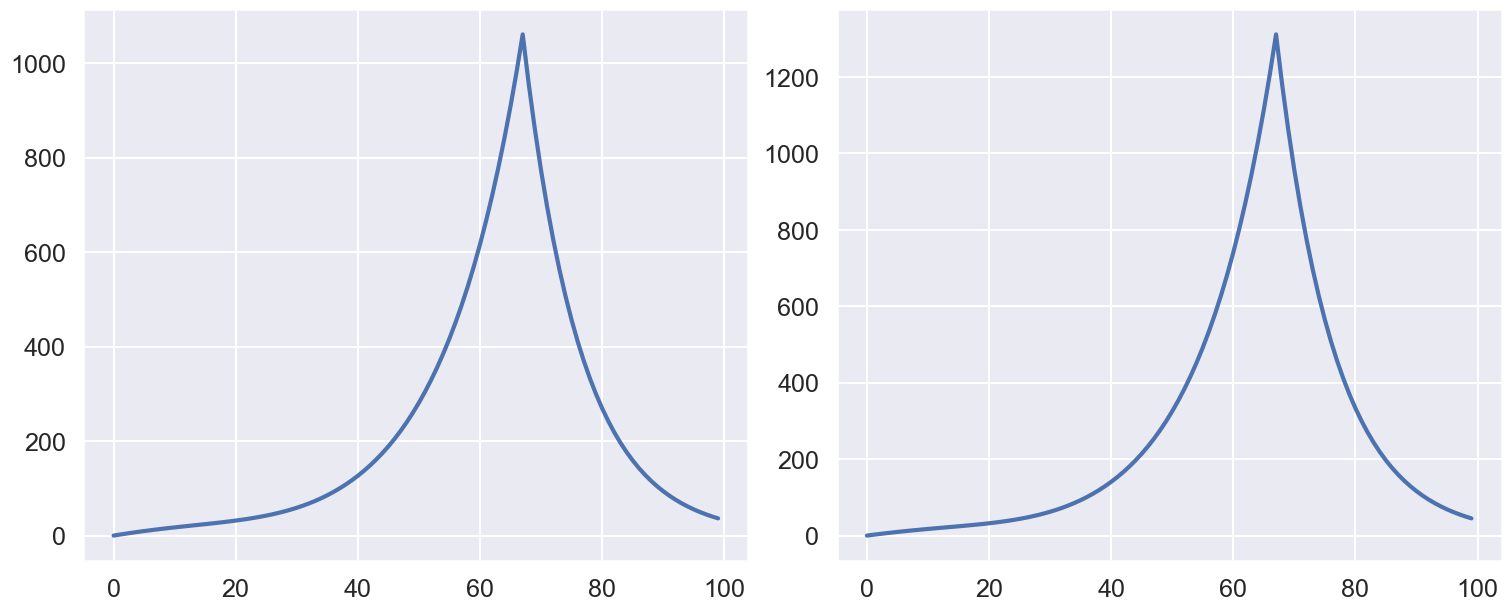

In [17]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15, 6),
    constrained_layout=True)

axes = axes.flatten()

n0 = np.array([[0], [50], [0], [0], [0], [0], [0], [0], [0], [0], [0], [50], [0], [0], [0], [0], [0], [0], [0], [0]])
pop = Population2(n0, consumption=0.01, α=0.001)
pop.diet = 'OP50'
n_list = []
r_list = []
for i in range(100):
    n_list.append(pop.pop)
    r_list.append(pop.resource)
    pop.take_a_step()
    
# axes[0].plot([m[11][0] for m in n_list], lw=3, label='Juveniles')
# axes[0].plot([m[12][0] for m in n_list], lw=3, label='Dauer')
axes[0].plot([np.sum(m[13:20]) for m in n_list], lw=3, label='Adults')
# axes[0].plot(r_list, lw=3, color='gray', label='Resource')


# axes[1].plot([m[1][0] for m in n_list], lw=3, label='Juveniles')
# axes[1].plot([m[2][0] for m in n_list], lw=3, label='Dauer')
axes[1].plot([np.sum(m[3:10]) for m in n_list], lw=3, label='Adults')


# n0 = np.array([[0], [50], [0], [0], [0], [0], [0], [0], [0], [0], [0], [50], [0], [0], [0], [0], [0], [0], [0], [0]])
# pop = Population(n0, consumption=0.01, α=0.001)
# pop.diet = 'OP50'
# n_list = []
# r_list = []
# for i in range(100):
#     n_list.append(pop.pop)
#     r_list.append(pop.resource)
#     pop.take_a_step()
    
# # axes[0].plot([m[11][0] for m in n_list], lw=3, ls='dashed', label='Juveniles')
# # axes[0].plot([m[12][0] for m in n_list], lw=3, ls='dashed', label='Dauer')
# axes[0].plot([np.sum(m[13:20]) for m in n_list], lw=3, ls='dashed', label='Adults')

# # axes[1].plot([m[1][0] for m in n_list], lw=3, ls='dashed', label='Juveniles')
# # axes[1].plot([m[2][0] for m in n_list], lw=3, ls='dashed', label='Dauer')
# axes[1].plot([np.sum(m[3:10]) for m in n_list], lw=3, ls='dashed', label='Adults')

In [22]:
n0 = np.array([[0], [100], [0], [0], [0], [0], [0], [0], [0], [0], [0], [100], [0], [0], [0], [0], [0], [0], [0], [0]])
pop = Population2(n0, consumption=0.01, α=1e-4)
pop.diet = 'OP50'

In [23]:
pop.p_mat

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  , -0.01, -0.01, -0.01, -0.01, -0.01,
        -0.01, -0.01],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  , -0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ],
       [ 0